In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Subset,random_split,Dataset

from sklearn.model_selection import train_test_split

from torchsummary import summary
from PIL import Image
import torchvision
from torchvision import transforms
from torchvision.io import read_image
from pathlib import Path

import time

import random

import copy

import sklearn.metrics as skm

from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
class StrokeDataset(Dataset):
    def __init__(self, root_path, test=False):
        self.root_path = root_path
        if test:
            self.images = sorted([os.path.join(root_path, "Test", i) for i in os.listdir(os.path.join(root_path, "Test"))])
            self.masks = sorted([os.path.join(root_path, "Test_mask", i) for i in os.listdir(os.path.join(root_path, "Test_mask"))])
        else:
            self.images = sorted([os.path.join(root_path, "Train", i) for i in os.listdir(os.path.join(root_path, "Train"))])
            self.masks = sorted([os.path.join(root_path, "Train_mask", i) for i in os.listdir(os.path.join(root_path, "Train_mask"))])

        # Ensure the number of images and masks match
        assert len(self.images) == len(self.masks), "Mismatch between number of images and masks!"

        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor()
        ])

    def __getitem__(self, index):
        # Load image and mask
        img = Image.open(self.images[index]).convert("RGB")
        mask = Image.open(self.masks[index]).convert("L")  # Grayscale mask

        # Apply transformations
        transformed_img = self.transform(img)
        transformed_mask = self.transform(mask)

        # Create binary label: 0 for pure black (no segmentation), 1 for any non-black (segmentation present)
        binary_label = torch.tensor(float(torch.any(transformed_mask > 0)), dtype=torch.float32)

        return transformed_img, transformed_mask, binary_label

    def __len__(self):
        return len(self.images)

In [ ]:
DATA_PATH = "/content/drive/MyDrive/unet_dataset"

In [ ]:
train_dataset = StrokeDataset(DATA_PATH)

train_dataset, dev_dataset = random_split(train_dataset, [0.8, 0.2])

train_loader = DataLoader(dataset=train_dataset,
                            batch_size=32,
                            shuffle=True)
dev_loader = DataLoader(dataset=dev_dataset,
                            batch_size=32,
                            shuffle=True)

In [ ]:
class CNNVAE(nn.Module):
    def __init__(self):
        super(CNNVAE, self).__init__()

        # Encoder: Downsampling path
        self.encoder1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 256x256 -> 128x128
        )
        self.encoder2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 128x128 -> 64x64
        )
        self.encoder3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 64x64 -> 32x32
        )
        self.encoder4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 32x32 -> 16x16
        )
        self.latent_conv = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.fc_mu = nn.Conv2d(256, 256, 1)  # Match latent space channels
        self.fc_logvar = nn.Conv2d(256, 256, 1)

        # Decoder: Upsampling path (adjusted for 256x256 input)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),  # 16x16 -> 32x32
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),  # 32x32 -> 64x64
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),  # 64x64 -> 128x128
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),  # 128x128 -> 256x256
            nn.ReLU(),
            nn.Conv2d(16, 3, kernel_size=3, padding=1),  # 256x256 -> 256x256, 3 channels
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def forward(self, x):
        # Encoder path with intermediate outputs
        enc1 = self.encoder1(x)  # 16 channels, 128x128
        enc2 = self.encoder2(enc1)  # 32 channels, 64x64
        enc3 = self.encoder3(enc2)  # 64 channels, 32x32
        enc4 = self.encoder4(enc3)  # 128 channels, 16x16
        latent = self.latent_conv(enc4)  # 256 channels, 16x16

        # Latent space parameters
        mu = self.fc_mu(latent)
        logvar = self.fc_logvar(latent)
        z = self.reparameterize(mu, logvar)

        # Decode
        reconstructed = self.decoder(z)

        return reconstructed, [enc1, enc2, enc3, enc4], z, mu, logvar

In [ ]:
class CNNclassification(nn.Module):
    def __init__(self, printtoggle=False):
        super().__init__()
        self.print = printtoggle

        # First Convolutional Layer
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(16)

        # Second Convolutional Layer
        self.conv2 = nn.Conv2d(16 + 16, 32, 3, padding=1)  # +16 from enc1
        self.bnorm2 = nn.BatchNorm2d(32)

        # Third Convolutional Layer
        self.conv3 = nn.Conv2d(32 + 32, 64, 3, padding=1)  # +32 from enc2
        self.bnorm3 = nn.BatchNorm2d(64)

        # Fourth Convolutional Layer
        self.conv4 = nn.Conv2d(64 + 64, 128, 3, padding=1)  # +64 from enc3
        self.bnorm4 = nn.BatchNorm2d(128)

        # Fifth Convolutional Layer
        self.conv5 = nn.Conv2d(128 + 128 + 256, 128, 3, padding=1)  # +128 from enc4, +256 from z
        self.bnorm5 = nn.BatchNorm2d(128)

        # Process reconstructed image
        self.reconstructed_conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(16, 16)  # 256x256 -> 16x16
        )

        # Linear Decision Layers
        self.fc1 = nn.Linear(128 * 8 * 8 + 16 * 16 * 16, 512)  # 8192 + 4096 = 12288
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 16)
        self.fc7 = nn.Linear(16, 8)
        self.fc8 = nn.Linear(8, 1)  # Binary classification (2 classes)

    def forward(self, x, enc_features, z, reconstructed):
        if self.print: print(f"Input shape: {x.shape}")

        # First Convolutional Layer
        x = F.max_pool2d(self.conv1(x), 2)  # 256x256 -> 128x128
        x = self.bnorm1(F.relu(x))
        x = torch.cat((x, enc_features[0]), dim=1)  # +16 channels from enc1
        if self.print: print(f"After conv1: {x.shape}")

        # Second Convolutional Layer
        x = F.max_pool2d(self.conv2(x), 2)  # 128x128 -> 64x64
        x = self.bnorm2(F.relu(x))
        x = torch.cat((x, enc_features[1]), dim=1)  # +32 channels from enc2
        if self.print: print(f"After conv2: {x.shape}")

        # Third Convolutional Layer
        x = F.max_pool2d(self.conv3(x), 2)  # 64x64 -> 32x32
        x = self.bnorm3(F.relu(x))
        x = torch.cat((x, enc_features[2]), dim=1)  # +64 channels from enc3
        if self.print: print(f"After conv3: {x.shape}")

        # Fourth Convolutional Layer
        x = F.max_pool2d(self.conv4(x), 2)  # 32x32 -> 16x16
        x = self.bnorm4(F.relu(x))
        x = torch.cat((x, enc_features[3], z), dim=1)  # +128 from enc4, +256 from z
        if self.print: print(f"After conv4: {x.shape}")

        # Fifth Convolutional Layer
        x = F.max_pool2d(self.conv5(x), 2)  # 16x16 -> 8x8
        x = self.bnorm5(F.relu(x))
        if self.print: print(f"After conv5: {x.shape}")

        # Process reconstructed image
        recon = self.reconstructed_conv(reconstructed)  # 256x256 -> 16x16
        if self.print: print(f"Reconstructed conv shape: {recon.shape}")

        # Flatten and concatenate
        x = x.view(x.size(0), -1)  # [batch_size, 8192]
        recon = recon.view(recon.size(0), -1)  # [batch_size, 4096]
        combined = torch.cat((x, recon), dim=1)  # [batch_size, 12288]
        if self.print: print(f"After flatten and concat: {combined.shape}")

        # Linear Decision Layers
        x = F.relu(self.fc1(combined))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))
        x = self.fc8(x)  # [batch_size, 2]
        if self.print: print(f"Output shape: {x.shape}")

        return x

In [ ]:
class CombinedModel(nn.Module):
    def __init__(self):
        super(CombinedModel, self).__init__()
        self.autoencoder = CNNVAE()
        self.classifier = CNNclassification(printtoggle=False)

    def forward(self, x):
        # Get outputs from autoencoder
        reconstructed, enc_features, latent, mu, logvar = self.autoencoder(x)

        # Feed into classifier
        out = self.classifier(x, enc_features, latent, reconstructed)
        return out, reconstructed,mu,logvar  # Return classification and reconstructed image

# Example usage
model = CombinedModel()
x = torch.randn(32, 3, 256, 256)  # Batch size 1, 1 channel, 128x128 image
out, reconstructed,mu,logvar = model(x)
print(f"Output shape: {out.shape}")  # Should be [1, 1] for binary classification
print(f"Reconstructed shape: {reconstructed.shape}")  # Should be [1, 3, 256, 256]

Output shape: torch.Size([32, 1])
Reconstructed shape: torch.Size([32, 1, 256, 256])


In [ ]:
classification_loss = nn.BCEWithLogitsLoss()

def VAE_lossfun(recon_x, x, mu, logvar, beta=1.0):
  # Reconstruction loss (MSE or BCE depending on your data)
  batch_size = x.size(0)
  MSE = nn.functional.mse_loss(recon_x, x, reduction='sum') / batch_size

  # KL Divergence
  KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / batch_size

  # Combined loss with beta weighting
  return MSE + beta * KLD

In [ ]:
net = CombinedModel()
optimizer = torch.optim.AdamW(net.parameters(), lr=1e-4)

In [ ]:
def func2TrainCombinedModel(printtoggle=True):

    timerInFunction = time.process_time()

    numepochs = 30

    # Early stopping parametreleri
    patience = 10  # Kaç epoch boyunca iyileşme olmazsa durdurulacak
    best_val_acc = 0.0  # En iyi doğrulama doğruluğu (accuracy için 0'dan başlıyoruz)
    counter = 0  # Sabır sayacı
    best_model = None  # En iyi model ağırlıklarını saklamak için

    net.to(device)

    trainAcc = torch.zeros(numepochs)
    trainLoss = torch.zeros(numepochs)
    devAcc = torch.zeros(numepochs)
    devLoss = torch.zeros(numepochs)

    for epoch in range(numepochs):

        train_running_loss = 0
        val_running_loss = 0

        net.train()

        batchAcc = []
        batchLoss = []

        for idx, (img, mask, label) in enumerate(tqdm(train_loader)):
            img = img.to(device)
            mask = mask.to(device)
            label = label.to(device)
            label = label.unsqueeze(1)

            yHat, reconstructed, mu, logvar = net(img)
            recon_loss = VAE_lossfun(reconstructed, mask, mu, logvar)
            class_loss = classification_loss(yHat, label)
            total_loss = recon_loss + class_loss

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            train_running_loss += total_loss.item()
            batchLoss.append(total_loss.item())
            batchAcc.append(torch.mean(((yHat > 0) == label).float()).item())

        train_loss = train_running_loss / (idx + 1)

        trainLoss[epoch] = np.mean(batchLoss)
        trainAcc[epoch] = 100*np.mean(batchAcc)

        net.eval()

        batchAcc = []
        batchLoss = []

        with torch.no_grad():
            for idx, (img, mask, label) in enumerate(tqdm(dev_loader)):
                img = img.to(device)
                mask = mask.to(device)
                label = label.to(device)
                label = label.unsqueeze(1)

                yHat, reconstructed, mu, logvar = net(img)
                recon_loss = VAE_lossfun(reconstructed, mask, mu, logvar)
                class_loss = classification_loss(yHat, label)
                total_loss = recon_loss + class_loss

                val_running_loss += total_loss.item()
                batchLoss.append(total_loss.item())
                batchAcc.append(torch.mean(((yHat > 0) == label).float()).item())

            val_loss = val_running_loss / (idx + 1)


        print("-"*30)
        print(f"Train Loss EPOCH {epoch+1}: {train_loss:.4f}")
        print(f"Valid Loss EPOCH {epoch+1}: {val_loss:.4f}")
        print("-"*30)

        current_val_loss = np.mean(batchLoss)
        current_val_acc = 100*np.mean(batchAcc)

        devLoss[epoch] = current_val_loss
        devAcc[epoch] = current_val_acc

        comptime = time.process_time() - timerInFunction

        if printtoggle:
            print(f'Epoch {epoch+1}/{numepochs} | Computing time: {comptime:.0f} sec | Train Accuracy: {trainAcc[epoch]:.2f}% | Validation Accuracy: {devAcc[epoch]:.2f}%')

        # Early stopping kontrolü (accuracy için)
        if current_val_acc > best_val_acc:  # Accuracy için ">" kullanıyoruz (daha yüksek daha iyi)
            best_val_acc = current_val_acc
            counter = 0
            # En iyi modeli kaydet
            best_model = copy.deepcopy(net.state_dict())

            if printtoggle:
                print(f"The validation accuracy saved! The best validation accuracy is: {best_val_acc:.2f}%")
                print("")
        else:
            counter += 1
            if printtoggle:
                print(f"Early stopping counter: {counter}/{patience}")
                print("")

            if counter >= patience:
                if printtoggle:
                    print(f"Early stopping! With epoch {epoch+1} training stopped.")
                    # En iyi modeli geri yükle
                net.load_state_dict(best_model)
                break

    # Eğer early stopping ile durdurulmadıysa, en iyi modeli yükle
    if best_model is not None and epoch == numepochs - 1:
        net.load_state_dict(best_model)
        if printtoggle:
            print("Training finished, the best model is loaded.")

    return trainAcc[:epoch+1], trainLoss[:epoch+1], devAcc[:epoch+1], devLoss[:epoch+1], net

In [ ]:
trainAcc, trainLoss, devAcc, devLoss, net = func2TrainCombinedModel(printtoggle=True)

100%|██████████| 28/28 [09:59<00:00, 21.41s/it]


------------------------------
Train Loss EPOCH 1: 14487.8760
Valid Loss EPOCH 1: 7347.6142
------------------------------
Epoch 1/30 | Computing time: 220 sec | Train Accuracy: 59.29% | Validation Accuracy: 72.07%
The validation accuracy saved! The best validation accuracy is: 72.07%



100%|██████████| 28/28 [00:11<00:00,  2.48it/s]


------------------------------
Train Loss EPOCH 2: 1809.8085
Valid Loss EPOCH 2: 797.8265
------------------------------
Epoch 2/30 | Computing time: 420 sec | Train Accuracy: 75.04% | Validation Accuracy: 75.66%
The validation accuracy saved! The best validation accuracy is: 75.66%



100%|██████████| 28/28 [00:11<00:00,  2.49it/s]


------------------------------
Train Loss EPOCH 3: 646.4986
Valid Loss EPOCH 3: 543.9685
------------------------------
Epoch 3/30 | Computing time: 619 sec | Train Accuracy: 82.56% | Validation Accuracy: 86.21%
The validation accuracy saved! The best validation accuracy is: 86.21%



100%|██████████| 28/28 [00:11<00:00,  2.48it/s]


------------------------------
Train Loss EPOCH 4: 507.6597
Valid Loss EPOCH 4: 480.0338
------------------------------
Epoch 4/30 | Computing time: 818 sec | Train Accuracy: 87.56% | Validation Accuracy: 87.77%
The validation accuracy saved! The best validation accuracy is: 87.77%



100%|██████████| 28/28 [00:11<00:00,  2.49it/s]


------------------------------
Train Loss EPOCH 5: 474.9624
Valid Loss EPOCH 5: 469.5872
------------------------------
Epoch 5/30 | Computing time: 1018 sec | Train Accuracy: 90.12% | Validation Accuracy: 87.90%
The validation accuracy saved! The best validation accuracy is: 87.90%



100%|██████████| 28/28 [00:11<00:00,  2.49it/s]


------------------------------
Train Loss EPOCH 6: 468.3963
Valid Loss EPOCH 6: 463.2339
------------------------------
Epoch 6/30 | Computing time: 1218 sec | Train Accuracy: 93.58% | Validation Accuracy: 90.20%
The validation accuracy saved! The best validation accuracy is: 90.20%



100%|██████████| 28/28 [00:11<00:00,  2.49it/s]


------------------------------
Train Loss EPOCH 7: 469.5044
Valid Loss EPOCH 7: 463.3552
------------------------------
Epoch 7/30 | Computing time: 1417 sec | Train Accuracy: 95.73% | Validation Accuracy: 90.48%
The validation accuracy saved! The best validation accuracy is: 90.48%



100%|██████████| 28/28 [00:11<00:00,  2.50it/s]


------------------------------
Train Loss EPOCH 8: 464.1377
Valid Loss EPOCH 8: 462.0623
------------------------------
Epoch 8/30 | Computing time: 1616 sec | Train Accuracy: 96.57% | Validation Accuracy: 92.04%
The validation accuracy saved! The best validation accuracy is: 92.04%



100%|██████████| 28/28 [00:11<00:00,  2.52it/s]


------------------------------
Train Loss EPOCH 9: 467.0540
Valid Loss EPOCH 9: 462.2184
------------------------------
Epoch 9/30 | Computing time: 1815 sec | Train Accuracy: 97.57% | Validation Accuracy: 93.97%
The validation accuracy saved! The best validation accuracy is: 93.97%



100%|██████████| 28/28 [00:11<00:00,  2.51it/s]


------------------------------
Train Loss EPOCH 10: 465.3699
Valid Loss EPOCH 10: 462.1303
------------------------------
Epoch 10/30 | Computing time: 2014 sec | Train Accuracy: 97.77% | Validation Accuracy: 94.25%
The validation accuracy saved! The best validation accuracy is: 94.25%



100%|██████████| 28/28 [00:11<00:00,  2.51it/s]


------------------------------
Train Loss EPOCH 11: 466.2313
Valid Loss EPOCH 11: 463.0292
------------------------------
Epoch 11/30 | Computing time: 2213 sec | Train Accuracy: 98.66% | Validation Accuracy: 94.17%
Early stopping counter: 1/10



100%|██████████| 28/28 [00:11<00:00,  2.48it/s]


------------------------------
Train Loss EPOCH 12: 464.0539
Valid Loss EPOCH 12: 462.0339
------------------------------
Epoch 12/30 | Computing time: 2413 sec | Train Accuracy: 98.77% | Validation Accuracy: 90.23%
Early stopping counter: 2/10



100%|██████████| 28/28 [00:11<00:00,  2.51it/s]


------------------------------
Train Loss EPOCH 13: 464.3501
Valid Loss EPOCH 13: 461.6034
------------------------------
Epoch 13/30 | Computing time: 2612 sec | Train Accuracy: 98.98% | Validation Accuracy: 95.62%
The validation accuracy saved! The best validation accuracy is: 95.62%



100%|██████████| 28/28 [00:11<00:00,  2.51it/s]


------------------------------
Train Loss EPOCH 14: 469.3204
Valid Loss EPOCH 14: 460.5609
------------------------------
Epoch 14/30 | Computing time: 2811 sec | Train Accuracy: 97.96% | Validation Accuracy: 89.97%
Early stopping counter: 1/10



100%|██████████| 28/28 [00:11<00:00,  2.51it/s]


------------------------------
Train Loss EPOCH 15: 461.7440
Valid Loss EPOCH 15: 462.0483
------------------------------
Epoch 15/30 | Computing time: 3011 sec | Train Accuracy: 99.41% | Validation Accuracy: 94.95%
Early stopping counter: 2/10



100%|██████████| 28/28 [00:11<00:00,  2.47it/s]


------------------------------
Train Loss EPOCH 16: 462.4884
Valid Loss EPOCH 16: 461.4218
------------------------------
Epoch 16/30 | Computing time: 3211 sec | Train Accuracy: 99.61% | Validation Accuracy: 95.14%
Early stopping counter: 3/10



100%|██████████| 28/28 [00:11<00:00,  2.46it/s]


------------------------------
Train Loss EPOCH 17: 462.4308
Valid Loss EPOCH 17: 462.7970
------------------------------
Epoch 17/30 | Computing time: 3409 sec | Train Accuracy: 99.53% | Validation Accuracy: 94.80%
Early stopping counter: 4/10



100%|██████████| 28/28 [00:11<00:00,  2.48it/s]


------------------------------
Train Loss EPOCH 18: 467.5612
Valid Loss EPOCH 18: 460.2272
------------------------------
Epoch 18/30 | Computing time: 3609 sec | Train Accuracy: 99.33% | Validation Accuracy: 94.69%
Early stopping counter: 5/10



100%|██████████| 28/28 [00:11<00:00,  2.53it/s]


------------------------------
Train Loss EPOCH 19: 462.1312
Valid Loss EPOCH 19: 462.4238
------------------------------
Epoch 19/30 | Computing time: 3809 sec | Train Accuracy: 99.14% | Validation Accuracy: 94.92%
Early stopping counter: 6/10



100%|██████████| 28/28 [00:11<00:00,  2.48it/s]


------------------------------
Train Loss EPOCH 20: 465.6629
Valid Loss EPOCH 20: 461.4736
------------------------------
Epoch 20/30 | Computing time: 4008 sec | Train Accuracy: 99.83% | Validation Accuracy: 95.62%
Early stopping counter: 7/10



100%|██████████| 28/28 [00:11<00:00,  2.50it/s]


------------------------------
Train Loss EPOCH 21: 469.2862
Valid Loss EPOCH 21: 459.4528
------------------------------
Epoch 21/30 | Computing time: 4208 sec | Train Accuracy: 100.00% | Validation Accuracy: 95.65%
The validation accuracy saved! The best validation accuracy is: 95.65%



100%|██████████| 28/28 [00:11<00:00,  2.37it/s]


------------------------------
Train Loss EPOCH 22: 464.6217
Valid Loss EPOCH 22: 463.1481
------------------------------
Epoch 22/30 | Computing time: 4409 sec | Train Accuracy: 100.00% | Validation Accuracy: 95.09%
Early stopping counter: 1/10



100%|██████████| 28/28 [00:11<00:00,  2.50it/s]


------------------------------
Train Loss EPOCH 23: 468.7478
Valid Loss EPOCH 23: 462.1898
------------------------------
Epoch 23/30 | Computing time: 4609 sec | Train Accuracy: 99.83% | Validation Accuracy: 91.15%
Early stopping counter: 2/10



100%|██████████| 28/28 [00:11<00:00,  2.50it/s]


------------------------------
Train Loss EPOCH 24: 462.4347
Valid Loss EPOCH 24: 461.3829
------------------------------
Epoch 24/30 | Computing time: 4808 sec | Train Accuracy: 98.16% | Validation Accuracy: 93.99%
Early stopping counter: 3/10



100%|██████████| 28/28 [00:11<00:00,  2.49it/s]


------------------------------
Train Loss EPOCH 25: 462.5615
Valid Loss EPOCH 25: 460.0523
------------------------------
Epoch 25/30 | Computing time: 5008 sec | Train Accuracy: 99.08% | Validation Accuracy: 94.83%
Early stopping counter: 4/10



100%|██████████| 28/28 [00:11<00:00,  2.51it/s]


------------------------------
Train Loss EPOCH 26: 473.4062
Valid Loss EPOCH 26: 461.5450
------------------------------
Epoch 26/30 | Computing time: 5208 sec | Train Accuracy: 99.67% | Validation Accuracy: 93.18%
Early stopping counter: 5/10



100%|██████████| 28/28 [00:11<00:00,  2.48it/s]


------------------------------
Train Loss EPOCH 27: 462.5140
Valid Loss EPOCH 27: 461.8983
------------------------------
Epoch 27/30 | Computing time: 5408 sec | Train Accuracy: 99.25% | Validation Accuracy: 94.83%
Early stopping counter: 6/10



100%|██████████| 28/28 [00:11<00:00,  2.48it/s]


------------------------------
Train Loss EPOCH 28: 465.8517
Valid Loss EPOCH 28: 461.2106
------------------------------
Epoch 28/30 | Computing time: 5607 sec | Train Accuracy: 99.69% | Validation Accuracy: 94.58%
Early stopping counter: 7/10



100%|██████████| 28/28 [00:11<00:00,  2.50it/s]


------------------------------
Train Loss EPOCH 29: 467.4134
Valid Loss EPOCH 29: 462.5821
------------------------------
Epoch 29/30 | Computing time: 5806 sec | Train Accuracy: 99.94% | Validation Accuracy: 95.73%
The validation accuracy saved! The best validation accuracy is: 95.73%



100%|██████████| 28/28 [00:11<00:00,  2.50it/s]

------------------------------
Train Loss EPOCH 30: 461.9019
Valid Loss EPOCH 30: 458.8883
------------------------------
Epoch 30/30 | Computing time: 6006 sec | Train Accuracy: 99.97% | Validation Accuracy: 95.58%
Early stopping counter: 1/10

Training finished, the best model is loaded.


In [ ]:
torch.cuda.empty_cache()

In [ ]:
def data_generator(path, target_size=(256, 256), augmentation=False, augmentation_factor=1):

    image_list = []

    base_transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x[:3,:,:])
    ])

    # Veri artırma dönüşümleri
    augmentation_transforms = [
        # Orijinal görüntü için baz dönüşüm
        base_transform,

        # Yatay döndürme
        transforms.Compose([
            transforms.Resize(target_size),
            transforms.RandomHorizontalFlip(p=1.0),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x[:3,:,:])
        ]),

        # Hafif döndürme
        transforms.Compose([
            transforms.Resize(target_size),
            transforms.RandomRotation(degrees=15),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x[:3,:,:])
        ]),

        # Parlaklık ve kontrast ayarları
        transforms.Compose([
            transforms.Resize(target_size),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x[:3,:,:])
        ]),

        # Hafif zoom
        transforms.Compose([
            transforms.Resize((int(target_size[0]*1.1), int(target_size[1]*1.1))),
            transforms.CenterCrop(target_size),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x[:3,:,:])
        ]),

        # Hafif bulanıklaştırma
        transforms.Compose([
            transforms.Resize(target_size),
            transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x[:3,:,:])
        ])
    ]

    image_files = sorted(os.listdir(path))

    for image_name in image_files:
        image_path = os.path.join(path, image_name)

        img = Image.open(image_path)

        # Orijinal görüntüyü ekle
        img_tensor = base_transform(img)
        image_list.append(img_tensor)

        # Eğer veri artırma isteniyorsa
        if augmentation:
            # Kaç tane dönüşüm uygulayacağımızı belirle (augmentation_factor kadar)
            num_transforms = min(augmentation_factor, len(augmentation_transforms)-1)

            # Dönüşümleri rastgele seç (ilk dönüşüm orijinal görüntü olduğu için 1'den başla)
            chosen_transforms = random.sample(range(1, len(augmentation_transforms)), num_transforms)

            for transform_idx in chosen_transforms:
                transform = augmentation_transforms[transform_idx]
                augmented_tensor = transform(img)
                image_list.append(augmented_tensor)

    data = torch.stack(image_list)
    return data

In [ ]:
# Test Verileri

folder_path_stroke = "/content/drive/MyDrive/veriler/test/inmeli"
folder_path_no_stroke = "/content/drive/MyDrive/veriler/test/inmesiz"

print("Images are loading...")
test_images_stroke = data_generator(folder_path_stroke, augmentation=False)
test_images_no_stroke = data_generator(folder_path_no_stroke, augmentation=False)

print(f"Total images: {test_images_stroke.shape[0]}")
print(f"Shapes: {test_images_stroke[0].shape}")

print(f"Total images: {test_images_no_stroke.shape[0]}")
print(f"Shapes: {test_images_no_stroke[0].shape}")


test_data = torch.cat([test_images_no_stroke, test_images_stroke], dim=0)
print(f"Combined test data shape: {test_data.shape}")

test_labels = torch.zeros(test_data.shape[0], dtype=torch.float)
test_labels[test_images_no_stroke.shape[0]:test_images_no_stroke.shape[0] + test_images_stroke.shape[0]] = 1.0
test_labels = test_labels[:, None]

test_ds = TensorDataset(test_data, test_labels)

test_loader = DataLoader(test_ds, batch_size=test_ds.tensors[0].shape[0],shuffle=True)


Images are loading...
Total images: 167
Shapes: torch.Size([3, 256, 256])
Total images: 130
Shapes: torch.Size([3, 256, 256])
Combined test data shape: torch.Size([297, 3, 256, 256])


In [ ]:
net.eval()

X,y = next(iter(test_loader))
X = X.to(device)
y = y.to(device)

with torch.no_grad():
  yHat, reconstructed, mu, logvar = net(X)
  class_loss = classification_loss(yHat,y)

testLoss = class_loss.item()
testAcc = 100*torch.mean( ( (yHat>0) == y ).float() ).item()

print(f"testLoss: {class_loss:.2f}")
print(f"Test Accuracy: {testAcc:.2f}")

testLoss: 0.54
Test Accuracy: 89.56


In [ ]:
import matplotlib.pyplot as plt
import torch

def visualize_reconstruction(model, data_loader, device, num_samples=5, has_ground_truth_mask=True):
    """
    Visualizes the input image, reconstructed mask, and optionally the ground truth mask.

    Args:
        model: The trained CombinedModel instance.
        data_loader: DataLoader containing the test dataset (images and labels, optionally masks).
        device: The device to run the model on (e.g., 'cuda' or 'cpu').
        num_samples: Number of samples to visualize (default: 5).
        has_ground_truth_mask: Whether the dataset includes ground truth masks (default: True).
    """
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient computation for inference
        # Get a batch from the data loader
        for batch in data_loader:
            if has_ground_truth_mask:
                images, masks, labels = batch
                images, masks, labels = images.to(device), masks.to(device), labels.to(device)
            else:
                images, labels = batch
                images, labels = images.to(device), labels.to(device)

            # Forward pass through the model
            yHat, reconstructed, mu, logvar = model(images)
            reconstructed = torch.sigmoid(reconstructed)  # Convert logits to probabilities

            # Visualize the specified number of samples
            for i in range(min(num_samples, images.size(0))):
                plt.figure(figsize=(12, 4 if has_ground_truth_mask else 8))

                # Plot the input image
                plt.subplot(1, 3 if has_ground_truth_mask else 2, 1)
                plt.title(f"Input Image (Label: {labels[i].item():.0f})")
                plt.imshow(images[i].permute(1, 2, 0).cpu().numpy())  # Convert CHW to HWC for plotting
                plt.axis('off')

                # Plot the reconstructed mask
                plt.subplot(1, 3 if has_ground_truth_mask else 2, 2)
                plt.title("Reconstructed Mask")
                plt.imshow(reconstructed[i].squeeze().cpu().numpy(), cmap='gray')  # Squeeze to remove channel dim
                plt.axis('off')

                # Plot the ground truth mask if available
                if has_ground_truth_mask:
                    plt.subplot(1, 3, 3)
                    plt.title("Ground Truth Mask")
                    plt.imshow(masks[i].squeeze().cpu().numpy(), cmap='gray')
                    plt.axis('off')

                plt.tight_layout()
                plt.show()

            break  # Only visualize one batch

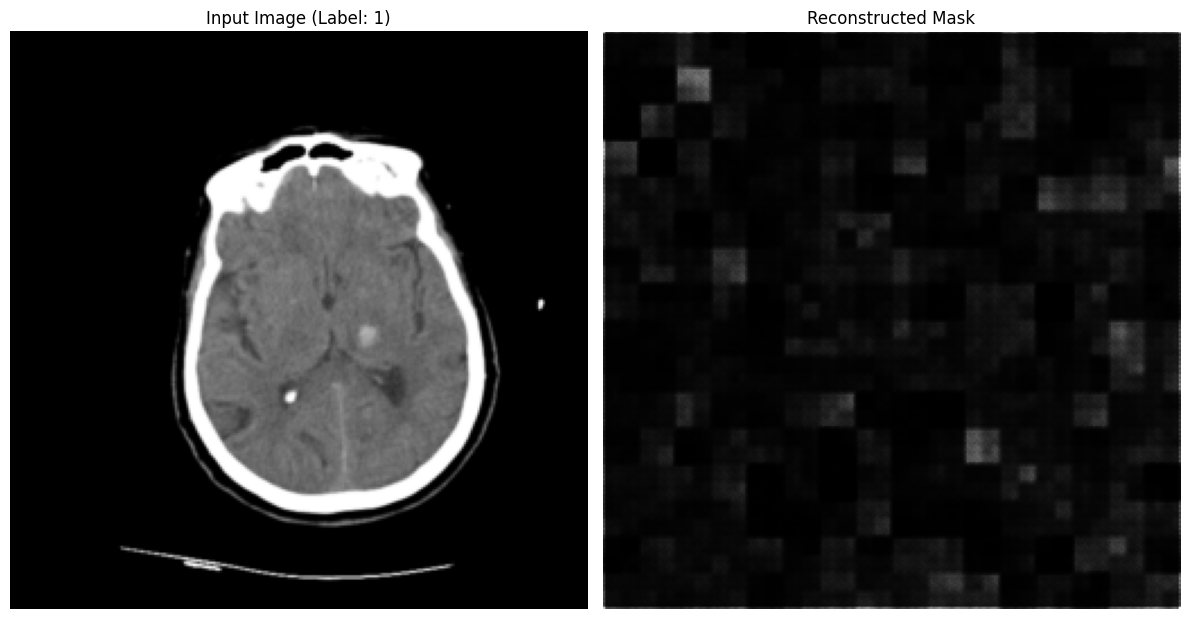

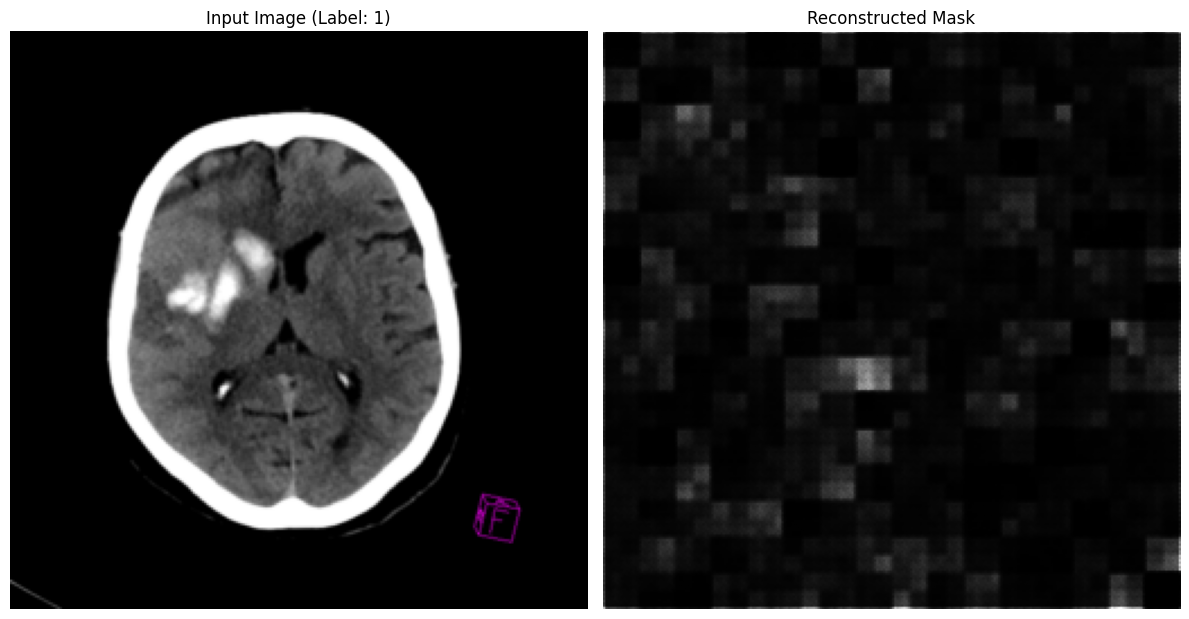

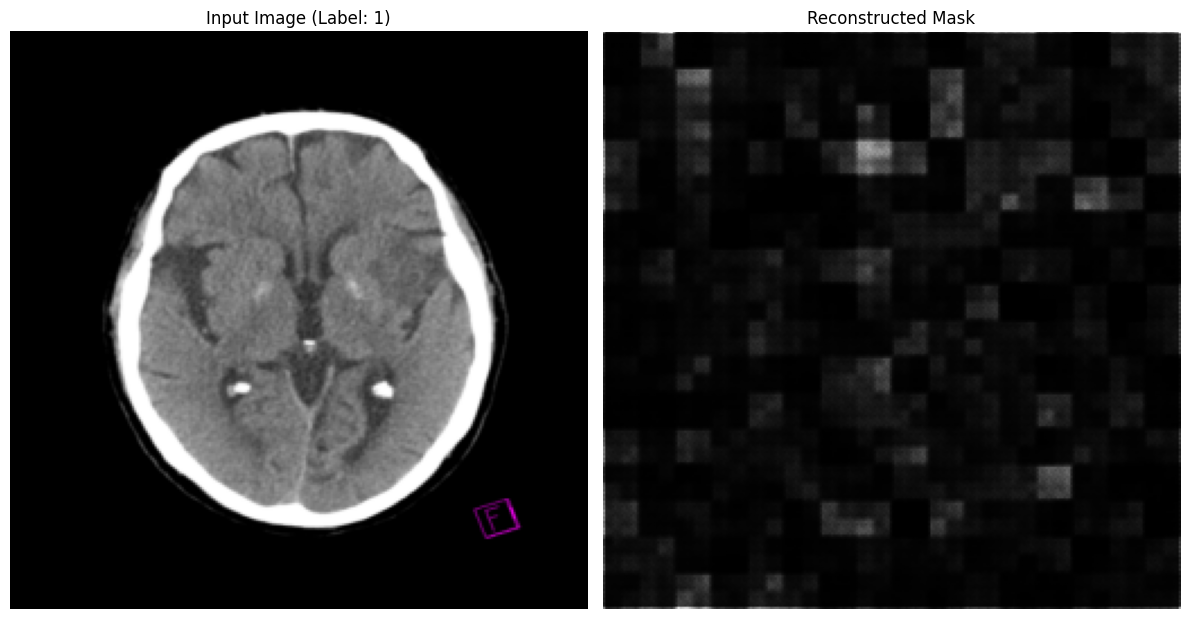

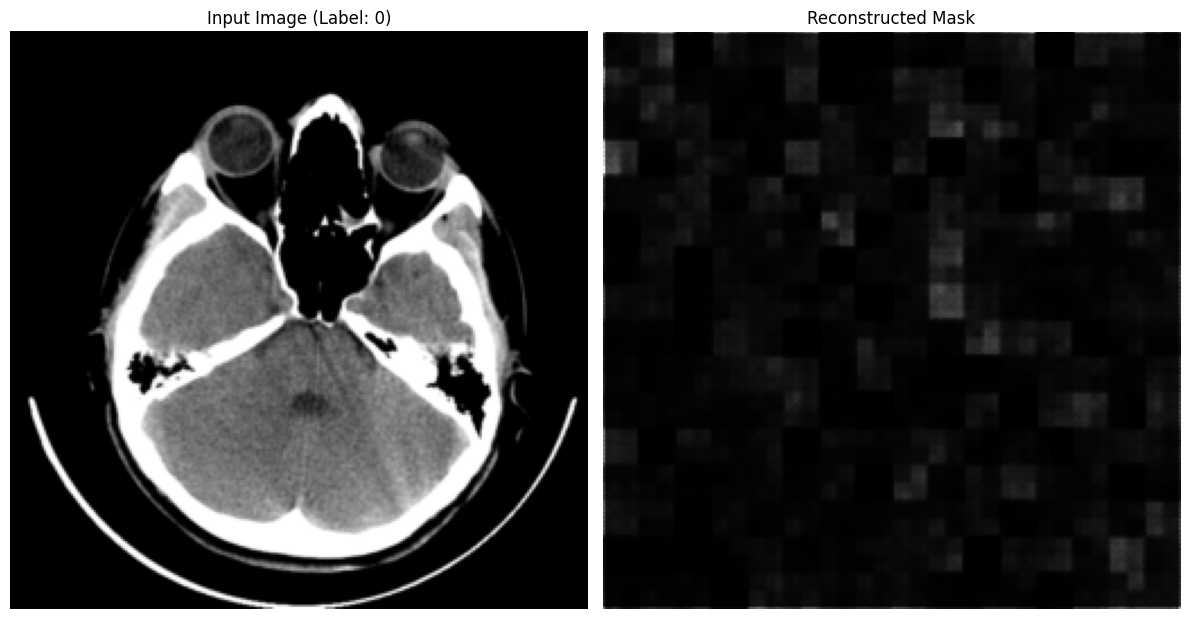

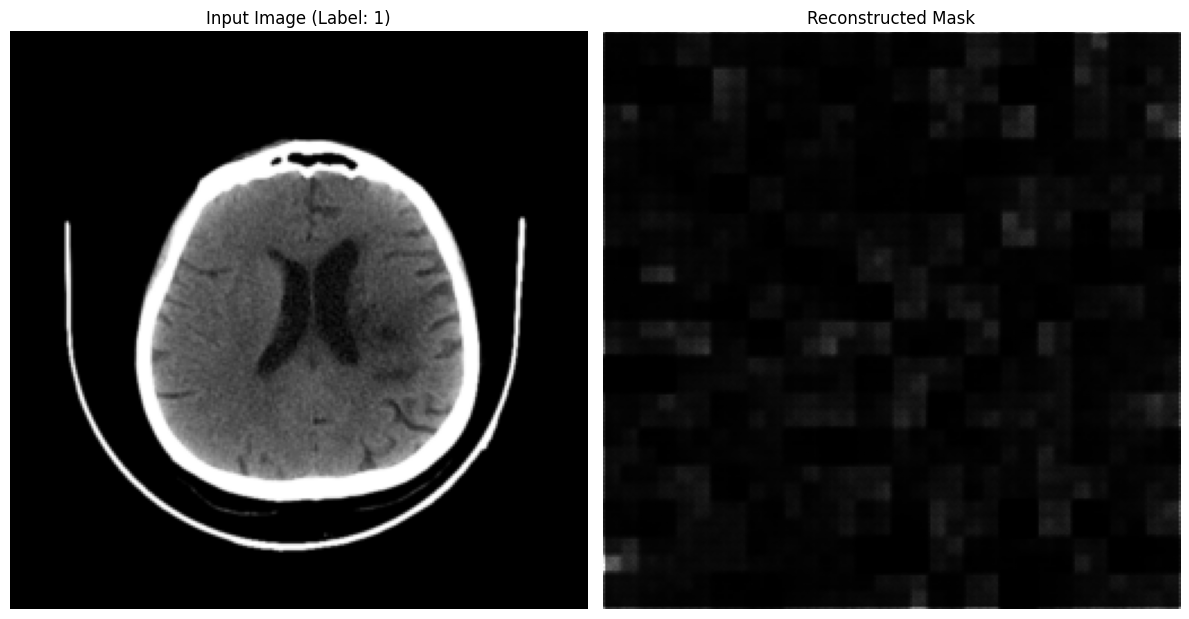

In [ ]:
# Assuming train_loader is your DataLoader for the training set
visualize_reconstruction(net, test_loader, device, num_samples=5, has_ground_truth_mask=False)

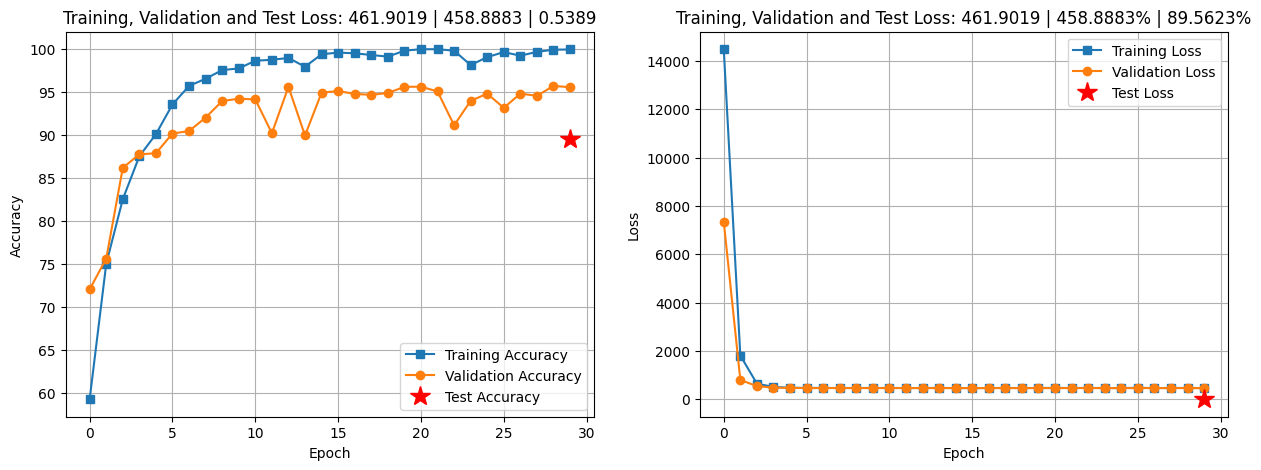

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(trainAcc,"s-", label='Training Accuracy')
ax[0].plot(devAcc,"o-", label='Validation Accuracy')
ax[0].plot(trainAcc.shape[0]-1,testAcc,"r*",markersize=15, label='Test Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].set_title(f'Training, Validation and Test Loss: {trainLoss[-1]:.4f} | {devLoss[-1]:.4f} | {testLoss:.4f}')
ax[0].grid()
ax[0].legend()

ax[1].plot(trainLoss,"s-", label='Training Loss')
ax[1].plot(devLoss,"o-", label='Validation Loss')
ax[1].plot(trainLoss.shape[0]-1,testLoss,"r*",markersize=15, label='Test Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_title(f'Training, Validation and Test Loss: {trainLoss[-1]:.4f} | {devLoss[-1]:.4f}% | {testAcc:.4f}%')
ax[1].grid()
ax[1].legend()

plt.show()

In [ ]:
folder_path_external_NS = "/content/drive/My Drive/veriler/test/baska_test/inmesiz"
external_NS_images = data_generator(folder_path_external_NS)
external_labels = torch.zeros(external_NS_images.shape[0])
external_labels = external_labels[:,None]
external_dataset = TensorDataset(external_NS_images, external_labels)
external_loader = DataLoader(external_dataset, batch_size=32, shuffle=False, drop_last=True)

In [ ]:
def get_predictions_memory_efficient(model, data_loader, device, has_mask=True):
    all_predictions = []
    all_labels = []
    all_reconstructed = []  # To store reconstructed masks for visualization

    # Process in smaller batches to reduce memory footprint
    with torch.no_grad():
        for data in data_loader:
            # Handle different tuple structures based on whether the dataset has masks
            if has_mask:
                X, _, y = data  # Train/dev: (image, mask, label)
            else:
                X, y = data  # Test: (image, label)

            # Move data to device
            X = X.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            # Forward pass
            yHat, reconstructed, mu, logvar = model(X)

            # Move predictions, labels, and reconstructed masks to CPU immediately
            all_predictions.append(yHat.cpu().detach())
            all_labels.append(y.cpu().detach())
            all_reconstructed.append(reconstructed.cpu().detach())

            # Clear GPU cache after each batch if using CUDA
            if device.type == 'cuda':
                torch.cuda.empty_cache()

    # Concatenate on CPU
    predictions = torch.cat(all_predictions)
    labels = torch.cat(all_labels)
    reconstructed = torch.cat(all_reconstructed)

    return predictions, labels, reconstructed

# Process each dataset separately to avoid keeping everything in memory at once
print("Processing train dataset...")
train_predictions, train_labels, train_reconstructed = get_predictions_memory_efficient(
    net, train_loader, device, has_mask=True
)
print(f"Train predictions shape: {train_predictions.shape}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Train reconstructed masks shape: {train_reconstructed.shape}")

print("Processing dev dataset...")
dev_predictions, dev_labels, dev_reconstructed = get_predictions_memory_efficient(
    net, dev_loader, device, has_mask=True
)
print(f"Dev predictions shape: {dev_predictions.shape}")
print(f"Dev labels shape: {dev_labels.shape}")
print(f"Dev reconstructed masks shape: {dev_reconstructed.shape}")

print("Processing test dataset...")
test_predictions, test_labels, test_reconstructed = get_predictions_memory_efficient(
    net, test_loader, device, has_mask=False
)
print(f"Test predictions shape: {test_predictions.shape}")
print(f"Test labels shape: {test_labels.shape}")
print(f"Test reconstructed masks shape: {test_reconstructed.shape}")


print("Processing test2 dataset...")
test2_predictions, test2_labels, test2_reconstructed = get_predictions_memory_efficient(
    net, external_loader, device, has_mask=False
)
print(f"Test predictions shape: {test2_predictions.shape}")
print(f"Test labels shape: {test2_labels.shape}")
print(f"Test reconstructed masks shape: {test2_reconstructed.shape}")

Processing train dataset...
Train predictions shape: torch.Size([3557, 1])
Train labels shape: torch.Size([3557])
Train reconstructed masks shape: torch.Size([3557, 1, 256, 256])
Processing dev dataset...
Dev predictions shape: torch.Size([889, 1])
Dev labels shape: torch.Size([889])
Dev reconstructed masks shape: torch.Size([889, 1, 256, 256])
Processing test dataset...
Test predictions shape: torch.Size([297, 1])
Test labels shape: torch.Size([297, 1])
Test reconstructed masks shape: torch.Size([297, 1, 256, 256])
Processing test2 dataset...
Test predictions shape: torch.Size([1536, 1])
Test labels shape: torch.Size([1536, 1])
Test reconstructed masks shape: torch.Size([1536, 1, 256, 256])


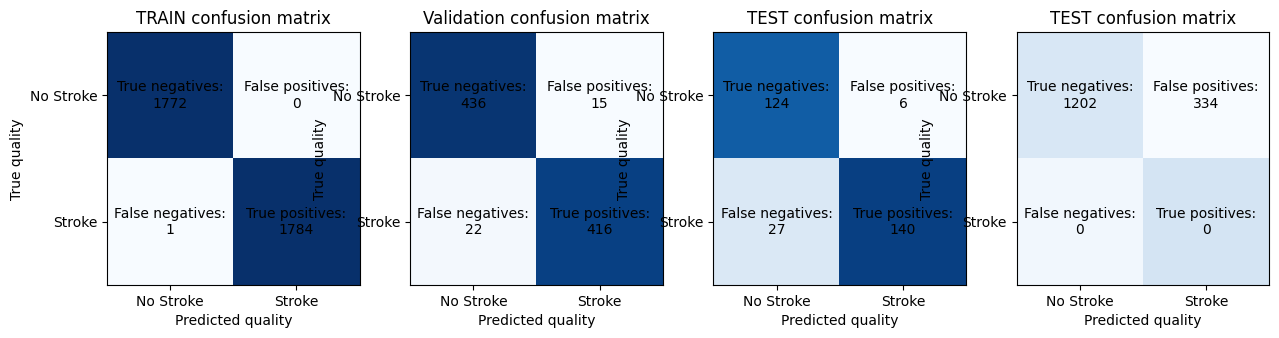

In [ ]:
# Confusion matrices
trainConf = skm.confusion_matrix(train_labels.cpu(), (train_predictions>0).cpu())
devConf = skm.confusion_matrix(dev_labels.cpu(), (dev_predictions>0).cpu())
testConf = skm.confusion_matrix(test_labels.cpu(), (test_predictions>0).cpu())
test2Conf = skm.confusion_matrix(test2_labels.cpu(), (test2_predictions>0).cpu())

fig,ax = plt.subplots(1,4,figsize=(15,4))

# confmat during TRAIN
ax[0].imshow(trainConf,'Blues',vmax=len(train_predictions)/2)
ax[0].set_xticks([0,1])
ax[0].set_yticks([0,1])
ax[0].set_xticklabels(['No Stroke','Stroke'])
ax[0].set_yticklabels(['No Stroke','Stroke'])
ax[0].set_xlabel('Predicted quality')
ax[0].set_ylabel('True quality')
ax[0].set_title('TRAIN confusion matrix')

# add text labels
ax[0].text(0,0,f'True negatives:\n{trainConf[0,0]}' ,ha='center',va='center')
ax[0].text(0,1,f'False negatives:\n{trainConf[1,0]}',ha='center',va='center')
ax[0].text(1,1,f'True positives:\n{trainConf[1,1]}' ,ha='center',va='center')
ax[0].text(1,0,f'False positives:\n{trainConf[0,1]}',ha='center',va='center')

# confmat during DEV
ax[1].imshow(devConf,'Blues',vmax=len(dev_predictions)/2)
ax[1].set_xticks([0,1])
ax[1].set_yticks([0,1])
ax[1].set_xticklabels(['No Stroke','Stroke'])
ax[1].set_yticklabels(['No Stroke','Stroke'])
ax[1].set_xlabel('Predicted quality')
ax[1].set_ylabel('True quality')
ax[1].set_title('Validation confusion matrix')

# add text labels
ax[1].text(0,0,f'True negatives:\n{devConf[0,0]}' ,ha='center',va='center')
ax[1].text(0,1,f'False negatives:\n{devConf[1,0]}',ha='center',va='center')
ax[1].text(1,1,f'True positives:\n{devConf[1,1]}' ,ha='center',va='center')
ax[1].text(1,0,f'False positives:\n{devConf[0,1]}',ha='center',va='center')

# confmat during TEST
ax[2].imshow(testConf,'Blues',vmax=len(test_predictions)/2)
ax[2].set_xticks([0,1])
ax[2].set_yticks([0,1])
ax[2].set_xticklabels(['No Stroke','Stroke'])
ax[2].set_yticklabels(['No Stroke','Stroke'])
ax[2].set_xlabel('Predicted quality')
ax[2].set_ylabel('True quality')
ax[2].set_title('TEST confusion matrix')

# add text labels
ax[2].text(0,0,f'True negatives:\n{testConf[0,0]}' ,ha='center',va='center')
ax[2].text(0,1,f'False negatives:\n{testConf[1,0]}',ha='center',va='center')
ax[2].text(1,1,f'True positives:\n{testConf[1,1]}' ,ha='center',va='center')
ax[2].text(1,0,f'False positives:\n{testConf[0,1]}',ha='center',va='center')



# confmat during TEST2
ax[3].imshow(testConf,'Blues',vmax=len(test2_predictions)/2)
ax[3].set_xticks([0,1])
ax[3].set_yticks([0,1])
ax[3].set_xticklabels(['No Stroke','Stroke'])
ax[3].set_yticklabels(['No Stroke','Stroke'])
ax[3].set_xlabel('Predicted quality')
ax[3].set_ylabel('True quality')
ax[3].set_title('TEST confusion matrix')

# add text labels
ax[3].text(0,0,f'True negatives:\n{test2Conf[0,0]}' ,ha='center',va='center')
ax[3].text(0,1,f'False negatives:\n{test2Conf[1,0]}',ha='center',va='center')
ax[3].text(1,1,f'True positives:\n{test2Conf[1,1]}' ,ha='center',va='center')
ax[3].text(1,0,f'False positives:\n{test2Conf[0,1]}',ha='center',va='center')

plt.show()

In [ ]:
# initialize vectors
train_metrics = [0,0,0,0,0,0,0]
dev_metrics = [0,0,0,0,0,0,0]
test_metrics = [0,0,0,0,0,0,0]
test2_metrics = [0,0,0,0,0,0,0]

tn, fp, fn, tp = skm.confusion_matrix(train_labels.cpu(),(train_predictions>0).cpu()).ravel()

# training
train_metrics[0] = skm.accuracy_score   (train_labels.cpu(),(train_predictions>0).cpu())
train_metrics[1] = skm.precision_score  (train_labels.cpu(),(train_predictions>0).cpu())
train_metrics[2] = skm.recall_score     (train_labels.cpu(),(train_predictions>0).cpu())
train_metrics[3] = tn / (tn + fp) # specificity
train_metrics[4] = skm.f1_score         (train_labels.cpu(),(train_predictions>0).cpu())
train_metrics[5] = skm.roc_auc_score    (train_labels.cpu(),(train_predictions>0).cpu())
train_metrics[6] = np.sqrt(train_metrics[1] * train_metrics[3]) # g-mean

tn, fp, fn, tp = skm.confusion_matrix(dev_labels.cpu(),(dev_predictions>0).cpu()).ravel()

# validation
dev_metrics[0] = skm.accuracy_score     (dev_labels.cpu(),(dev_predictions>0).cpu())
dev_metrics[1] = skm.precision_score    (dev_labels.cpu(),(dev_predictions>0).cpu())
dev_metrics[2] = skm.recall_score       (dev_labels.cpu(),(dev_predictions>0).cpu())
dev_metrics[3] = tn / (tn + fp) # specificity
dev_metrics[4] = skm.f1_score           (dev_labels.cpu(),(dev_predictions>0).cpu())
dev_metrics[5] = skm.roc_auc_score      (dev_labels.cpu(), (dev_predictions>0).cpu())
dev_metrics[6] = np.sqrt(dev_metrics[1] * dev_metrics[3]) # g-mean

tn, fp, fn, tp = skm.confusion_matrix(test_labels.cpu(),(test_predictions>0).cpu()).ravel()

# test
test_metrics[0] = skm.accuracy_score     (test_labels.cpu(),(test_predictions>0).cpu())
test_metrics[1] = skm.precision_score    (test_labels.cpu(),(test_predictions>0).cpu())
test_metrics[2] = skm.recall_score       (test_labels.cpu(),(test_predictions>0).cpu())
test_metrics[3] = tn / (tn + fp) # specificity
test_metrics[4] = skm.f1_score           (test_labels.cpu(),(test_predictions>0).cpu())
test_metrics[5] = skm.roc_auc_score      (test_labels.cpu(), (test_predictions>0).cpu())
test_metrics[6] = np.sqrt(test_metrics[1] * test_metrics[3]) # g-mean



# test
test2_metrics[0] = skm.accuracy_score     (test2_labels.cpu(),(test2_predictions>0).cpu())
test2_metrics[1] = skm.precision_score    (test2_labels.cpu(),(test2_predictions>0).cpu())
test2_metrics[2] = skm.recall_score       (test2_labels.cpu(),(test2_predictions>0).cpu())
test2_metrics[3] = tn / (tn + fp) # specificity
test2_metrics[4] = skm.f1_score           (test2_labels.cpu(),(test2_predictions>0).cpu())
test2_metrics[5] = skm.roc_auc_score      (test2_labels.cpu(), (test2_predictions>0).cpu())
test2_metrics[6] = np.sqrt(test2_metrics[1] * test2_metrics[3]) # g-mean

# Accuracy = (TP + TN) / (TP + TN + FP + FN)

# Precision = TP / (TP + FP)

# Recall / Sensitivity = TP / (TP + FN)

# Specificity = TN / (TN + FP)

# F1 Score = 2 * (Precision * Recall) / (Precision + Recall) = 2*TP / (2*TP + FP + FN)

# G-Mean = sqrt(Sensitivity * Specificity)

# True Positive Rate (TPR) = TP / (TP + FN)

# False Positive Rate (FPR) = FP / (FP + TN) = 1 - Specificity

# AUC = ∫[0,1] TPR(FPR) dFPR

# TP = True Positive
# TN = True Negative
# FP = False Positive
# FN = False Negative

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


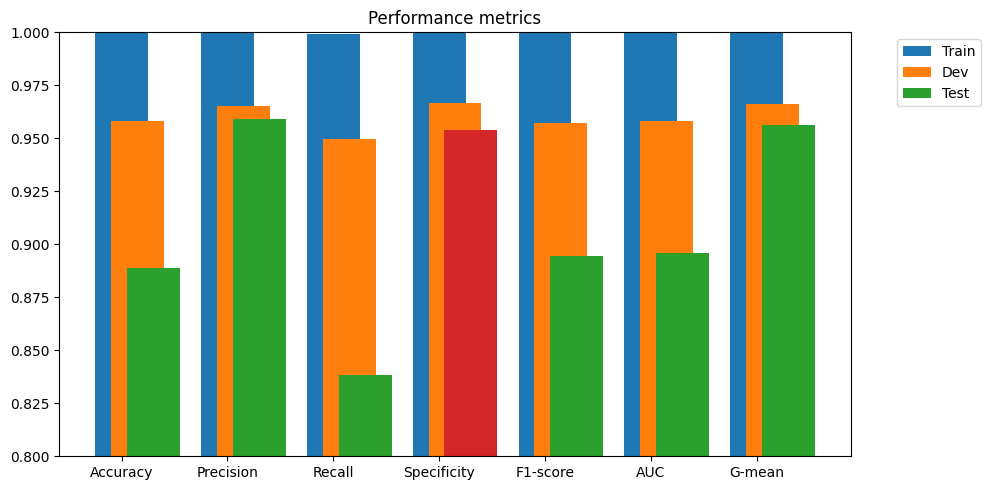

In [ ]:
plt.figure(figsize=(10, 5))

plt.bar(np.arange(7),train_metrics,.5)
plt.bar(np.arange(7)+.15,dev_metrics,.5)
plt.bar(np.arange(7)+.3,test_metrics,.5)
plt.bar(np.arange(7)+.3,test2_metrics,.5)
plt.xticks([0,1,2,3,4,5,6],['Accuracy','Precision','Recall','Specificity','F1-score','AUC','G-mean'])
plt.ylim([.8,1])
plt.legend(['Train','Dev','Test'], loc='upper left', bbox_to_anchor=(1.05, 1))
plt.title('Performance metrics')
plt.tight_layout()
plt.show()

In [ ]:
train_metrics = [0,0,0,0,0,0,0]
dev_metrics = [0,0,0,0,0,0,0]
test_metrics = [0,0,0,0,0,0,0]

tn, fp, fn, tp = skm.confusion_matrix(train_labels.cpu(),(train_predictions>0).cpu()).ravel()

# training
train_metrics[0] = skm.accuracy_score   (train_labels.cpu(),(train_predictions>0).cpu())
train_metrics[1] = skm.precision_score  (train_labels.cpu(),(train_predictions>0).cpu())
train_metrics[2] = skm.recall_score     (train_labels.cpu(),(train_predictions>0).cpu())
train_metrics[3] = tn / (tn + fp) # specificity
train_metrics[4] = skm.f1_score         (train_labels.cpu(),(train_predictions>0).cpu())
train_metrics[5] = skm.roc_auc_score    (train_labels.cpu(),(train_predictions>0).cpu())
train_metrics[6] = np.sqrt(train_metrics[1] * train_metrics[3]) # g-mean

tn, fp, fn, tp = skm.confusion_matrix(dev_labels.cpu(),(dev_predictions>0).cpu()).ravel()

# validation
dev_metrics[0] = skm.accuracy_score     (dev_labels.cpu(),(dev_predictions>0).cpu())
dev_metrics[1] = skm.precision_score    (dev_labels.cpu(),(dev_predictions>0).cpu())
dev_metrics[2] = skm.recall_score       (dev_labels.cpu(),(dev_predictions>0).cpu())
dev_metrics[3] = tn / (tn + fp) # specificity
dev_metrics[4] = skm.f1_score           (dev_labels.cpu(),(dev_predictions>0).cpu())
dev_metrics[5] = skm.roc_auc_score      (dev_labels.cpu(), (dev_predictions>0).cpu())
dev_metrics[6] = np.sqrt(dev_metrics[1] * dev_metrics[3]) # g-mean

tn, fp, fn, tp = skm.confusion_matrix(test_labels.cpu(),(test_predictions>0).cpu()).ravel()

# test
test_metrics[0] = skm.accuracy_score     (test_labels.cpu(),(test_predictions>0).cpu())
test_metrics[1] = skm.precision_score    (test_labels.cpu(),(test_predictions>0).cpu())
test_metrics[2] = skm.recall_score       (test_labels.cpu(),(test_predictions>0).cpu())
test_metrics[3] = tn / (tn + fp) # specificity
test_metrics[4] = skm.f1_score           (test_labels.cpu(),(test_predictions>0).cpu())
test_metrics[5] = skm.roc_auc_score      (test_labels.cpu(), (test_predictions>0).cpu())
test_metrics[6] = np.sqrt(test_metrics[1] * test_metrics[3]) # g-mean

# test2
test2_metrics[0] = skm.accuracy_score     (test2_labels.cpu(),(test2_predictions>0).cpu())
test2_metrics[1] = skm.precision_score    (test2_labels.cpu(),(test2_predictions>0).cpu())
test2_metrics[2] = skm.recall_score       (test2_labels.cpu(),(test2_predictions>0).cpu())
test2_metrics[3] = tn / (tn + fp) # specificity
test2_metrics[4] = skm.f1_score           (test2_labels.cpu(),(test2_predictions>0).cpu())
test2_metrics[5] = skm.roc_auc_score      (test2_labels.cpu(), (test2_predictions>0).cpu())
test2_metrics[6] = np.sqrt(test2_metrics[1] * test2_metrics[3]) # g-mean

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


In [ ]:
# Print out each metric numerically
print("\n===== PERFORMANCE METRICS =====")
print("\nTraining Set Metrics:")
print(f"Accuracy:    {train_metrics[0]:.4f}")
print(f"Precision:   {train_metrics[1]:.4f}")
print(f"Recall:      {train_metrics[2]:.4f}")
print(f"Specificity: {train_metrics[3]:.4f}")
print(f"F1 Score:    {train_metrics[4]:.4f}")
print(f"ROC AUC:     {train_metrics[5]:.4f}")
print(f"G-Mean:      {train_metrics[6]:.4f}")

print("\nValidation Set Metrics:")
print(f"Accuracy:    {dev_metrics[0]:.4f}")
print(f"Precision:   {dev_metrics[1]:.4f}")
print(f"Recall:      {dev_metrics[2]:.4f}")
print(f"Specificity: {dev_metrics[3]:.4f}")
print(f"F1 Score:    {dev_metrics[4]:.4f}")
print(f"ROC AUC:     {dev_metrics[5]:.4f}")
print(f"G-Mean:      {dev_metrics[6]:.4f}")

print("\nTest Set Metrics:")
print(f"Accuracy:    {test_metrics[0]:.4f}")
print(f"Precision:   {test_metrics[1]:.4f}")
print(f"Recall:      {test_metrics[2]:.4f}")
print(f"Specificity: {test_metrics[3]:.4f}")
print(f"F1 Score:    {test_metrics[4]:.4f}")
print(f"ROC AUC:     {test_metrics[5]:.4f}")
print(f"G-Mean:      {test_metrics[6]:.4f}")


print("\nTest Set 2 Metrics:")
print(f"Accuracy:    {test2_metrics[0]:.4f}")
print(f"Precision:   {test2_metrics[1]:.4f}")
print(f"Recall:      {test2_metrics[2]:.4f}")
print(f"Specificity: {test2_metrics[3]:.4f}")
print(f"F1 Score:    {test2_metrics[4]:.4f}")
print(f"ROC AUC:     {test2_metrics[5]:.4f}")
print(f"G-Mean:      {test2_metrics[6]:.4f}")


===== PERFORMANCE METRICS =====

Training Set Metrics:
Accuracy:    0.9997
Precision:   1.0000
Recall:      0.9994
Specificity: 1.0000
F1 Score:    0.9997
ROC AUC:     0.9997
G-Mean:      1.0000

Validation Set Metrics:
Accuracy:    0.9584
Precision:   0.9652
Recall:      0.9498
Specificity: 0.9667
F1 Score:    0.9574
ROC AUC:     0.9583
G-Mean:      0.9660

Test Set Metrics:
Accuracy:    0.8889
Precision:   0.9589
Recall:      0.8383
Specificity: 0.9538
F1 Score:    0.8946
ROC AUC:     0.8961
G-Mean:      0.9564

Test Set 2 Metrics:
Accuracy:    0.7826
Precision:   0.0000
Recall:      0.0000
Specificity: 0.9538
F1 Score:    0.0000
ROC AUC:     nan
G-Mean:      0.0000


In [ ]:
MODEL_PATH = "/content/drive/MyDrive/model_weights/CNN_VAE_model.pth"

In [ ]:
torch.save(net.state_dict(), MODEL_PATH)